## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'segmentAnything-full' 
TRANSFORM = 'wavelet-vertical'
CHANNEL = 'red'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
red_vertical_wavelet_full_segmentAnything.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/segmentAnything/full/wavelet/vertical/red'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 7072,
 3: 28288,
 4: 113152,
 5: 452608,
 6: 1810432,
 7: 7241728,
 8: 28966912,
 9: 115867648,
 10: 463470592}

Running 12760 CDFs


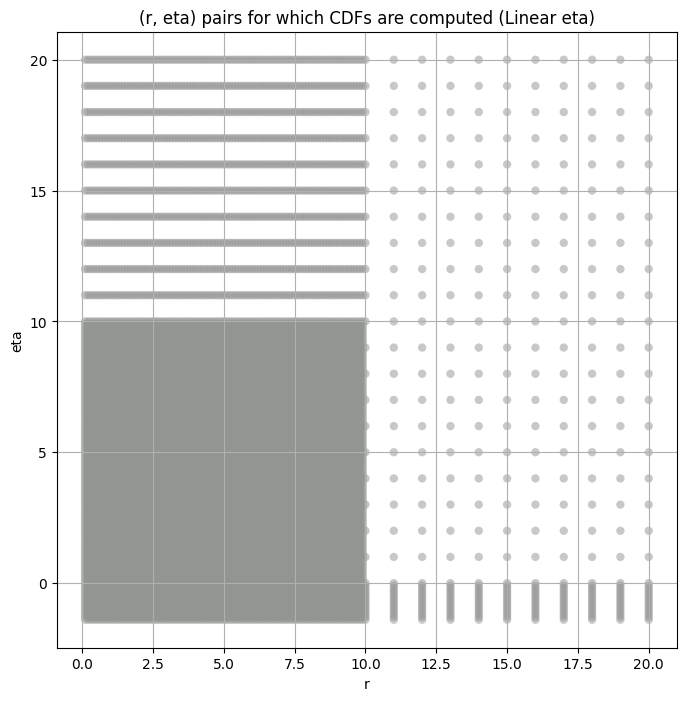

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 10


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                  
2      9603.463000  9062.190000  10164.071000   1.545066    1.144739   
3      2720.834200  2572.354200   2874.905000   2.626364    2.173408   
4       753.940200   707.069800    802.806600   4.000318    3.232317   
5       194.982000   181.976300    208.784120   5.163689    4.028322   
6        46.944320    43.397610     51.023575   7.649170    5.101356   
7        10.670525     9.762846     12.098597  14.009258    6.096832   
8         2.308390     2.097086      2.657379  17.870512    6.868606   
9         0.511854     0.459437      0.619605  29.756325    8.036207   
10        0.117195     0.104283      0.139264  28.386827   10.054461   

       kurt_upper  total_samples  
layer                             
2        2.002595           7072  
3        3.215686          28288  
4        5.090291         113152  
5        8.982092         452608  
6       20.824207        1810432  
7       66.927185        7241728  
8       87.880844       28966912  
9      173.595060      115867648  
10     137.195070      463470592

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      9603.463000    9603.462891     8695.803711     8126.701172   
3      2720.834200    2720.834229     2613.642334     2535.356934   
4       753.940200     753.940186      739.448914      729.765259   
5       194.982000     194.981995      190.702438      187.888565   
6        46.944320      46.944321       45.612255       44.824100   
7        10.670525      10.670525       10.279034       10.082465   
8         2.308390       2.308390        2.211622        2.165729   
9         0.511854       0.511854        0.485466        0.474025   
10        0.117195       0.117195        0.110552        0.107419   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         7680.729492      7297.208496      6664.037109      6140.992676   
3         2470.004639      2411.292725      2309.273438      2221.163818   
4          721.172974       713.262207       699.015930       685.976440   
5          185.444611       183.221817       179.218018       175.629379   
6           44.146194        43.534870        42.444252        41.474426   
7            9.913464         9.761157         9.490145         9.250103   
8            2.126490         2.091209         2.028596         1.973340   
9            0.464343         0.455725         0.440609         0.427420   
10           0.104810         0.102518         0.098553         0.095150   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          5687.537598      5292.325195      4940.826660      4050.713379  
3          2142.857178      2072.861084      2008.281006      1842.834106  
4           674.038208       663.008423       652.742554       625.448059  
5           172.322952       169.244629       166.362701       158.629471  
6            40.591660        39.776680        39.015137        36.983768  
7             9.032088         8.831500         8.644835         8.150422  
8             1.923428         1.877647         1.835248         1.723444  
9             0.415600         0.404836         0.394919         0.368969  
10            0.092140         0.089427         0.086950         0.080570

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.009949600811888504 9603.463


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.011434484982655979 8695.804


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.016175083526106526 8126.701


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.020232306982412185 7680.7295


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.02376858748917776 7297.2085


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.030461822561872687 6664.037


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.037094483406941325 6140.9927


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.04316285577902279 5687.5376


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.0490762156003397 5292.325


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.05471460726619937 4940.8267


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.07438587468032798 4050.7134
Number of samples: 7072, Without approximation : 7072


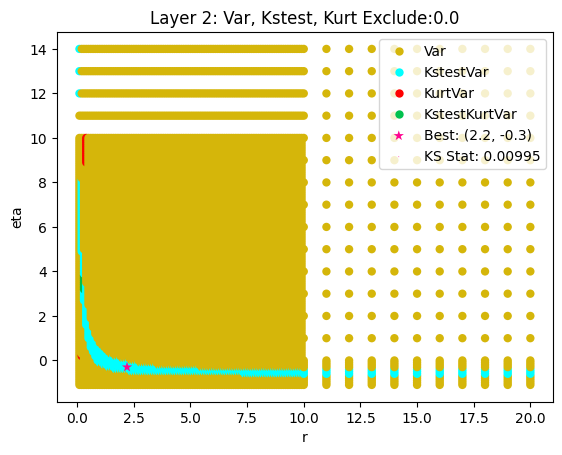

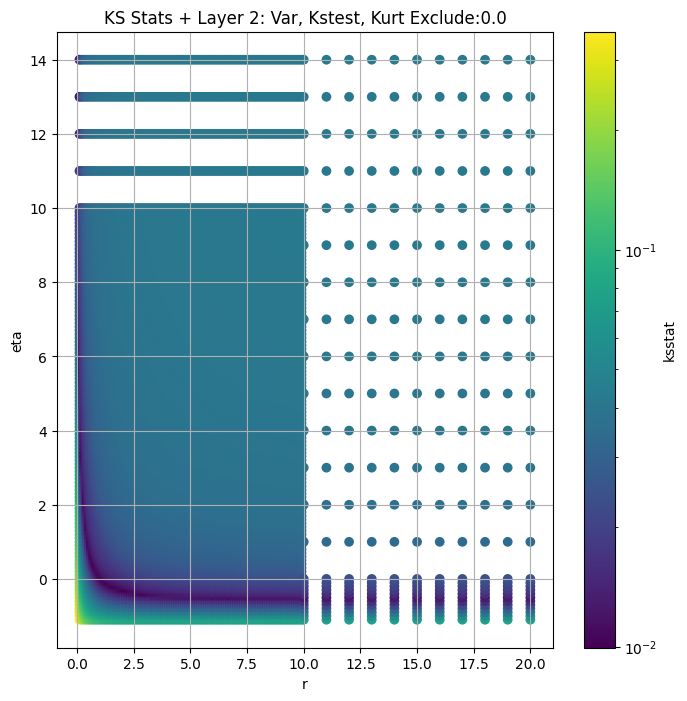

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.002473799784500047 2720.8342


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.003381670930666658 2613.6423


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.004754344087255058 2535.357


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.005670137191817859 2470.0046


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.006608232895987665 2411.2927


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.008648488210112326 2309.2734


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.010632112509018632 2221.1638


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.01258653300362822 2142.8572


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.014914159324297627 2072.861


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.016961152458403794 2008.281


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.022941997374460343 1842.8341
Number of samples: 28288, Without approximation : 28288


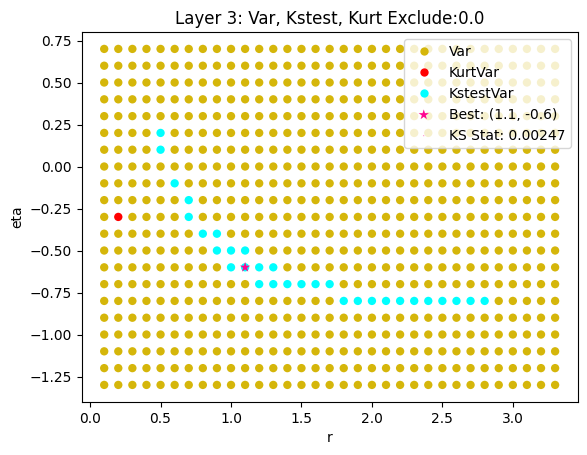

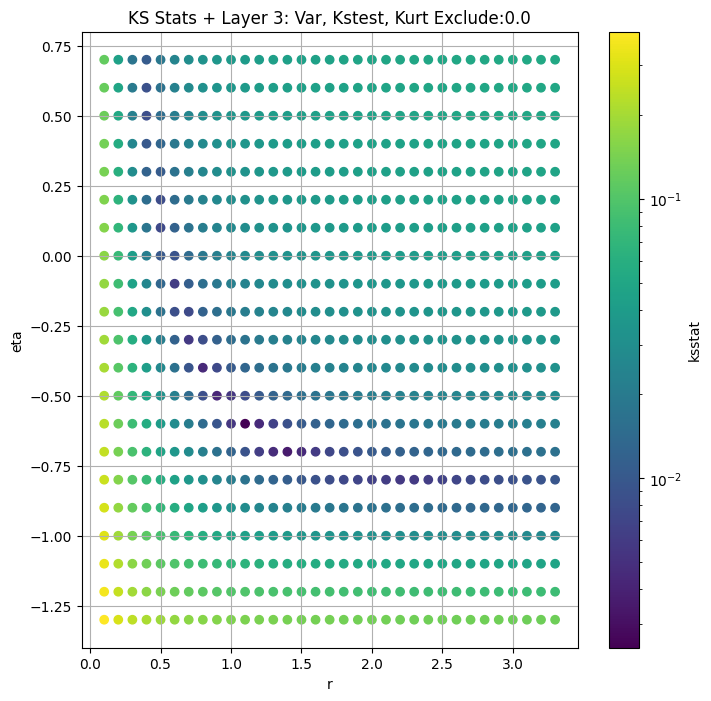

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.0030896841960712518 753.9402


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.0035608808604914374 739.4489


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.004317569472734442 729.76526


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.004229881967439564 721.173


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.004708873309119857 713.2622


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.005425655250642092 699.0159


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.005296149352735591 685.97644


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.005739766827169968 674.0382


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.006403809044597742 663.0084


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.007048138626397457 652.74255


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.008847176181930587 625.44806
Number of samples: 100000, Without approximation : 113152


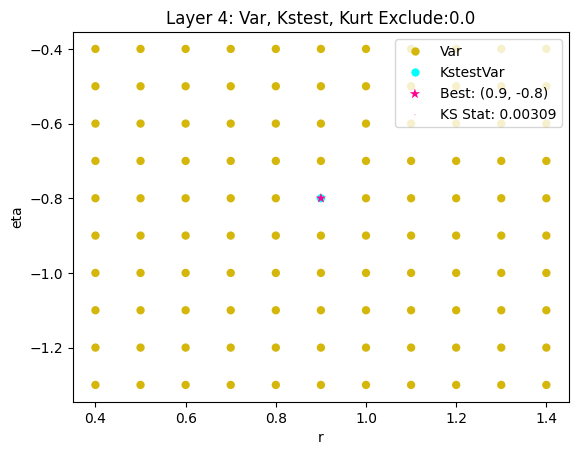

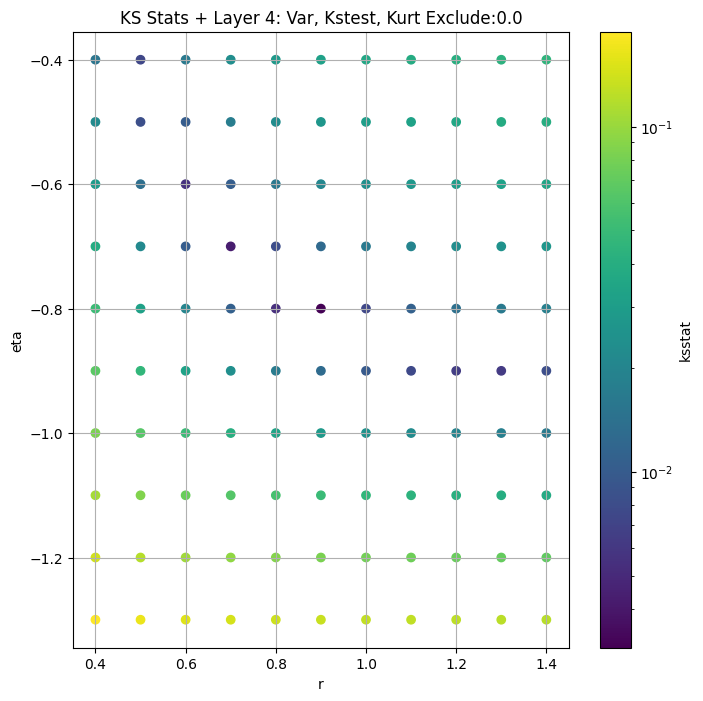

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.004275230159516696 194.982


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.004043958526038782 190.70244


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.004843783326749729 187.88857


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.005547016687746598 185.44461


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.005560058329525719 183.22182


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.006102850250222058 179.21802


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.006634584952348144 175.62938


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.0064551168328939035 172.32295


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.006800562656737008 169.24463


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.007410910192733433 166.3627


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.009214963349092331 158.62947
Number of samples: 100000, Without approximation : 452608


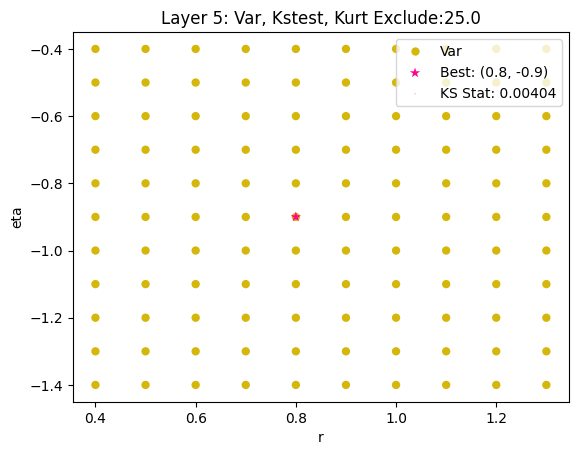

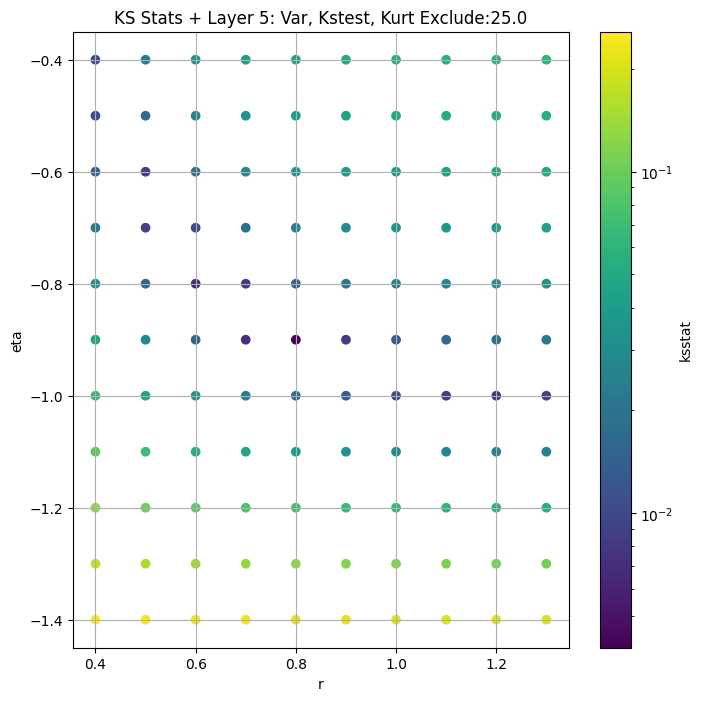

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.0035264952500849156 46.94432


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.004409201981416255 45.612255


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.005298404576679627 44.8241


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.006127473456920995 44.146194


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.006659297439177259 43.53487


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.006064188469915965 42.444252


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.006577106053114845 41.474426


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.006378139388989235 40.59166


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.007179134579669233 39.77668


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.007647251224420559 39.015137


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.009405651801687731 36.98377
Number of samples: 100000, Without approximation : 1810432


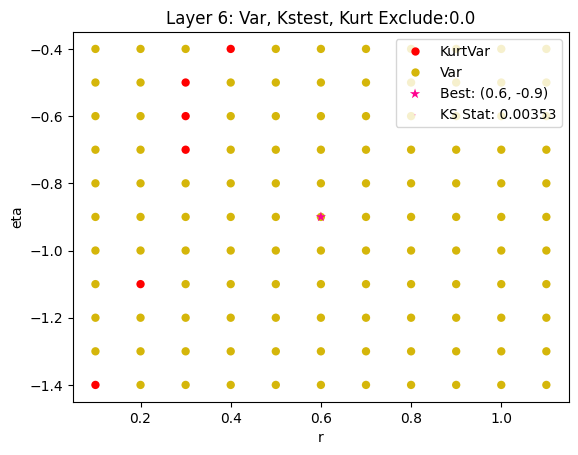

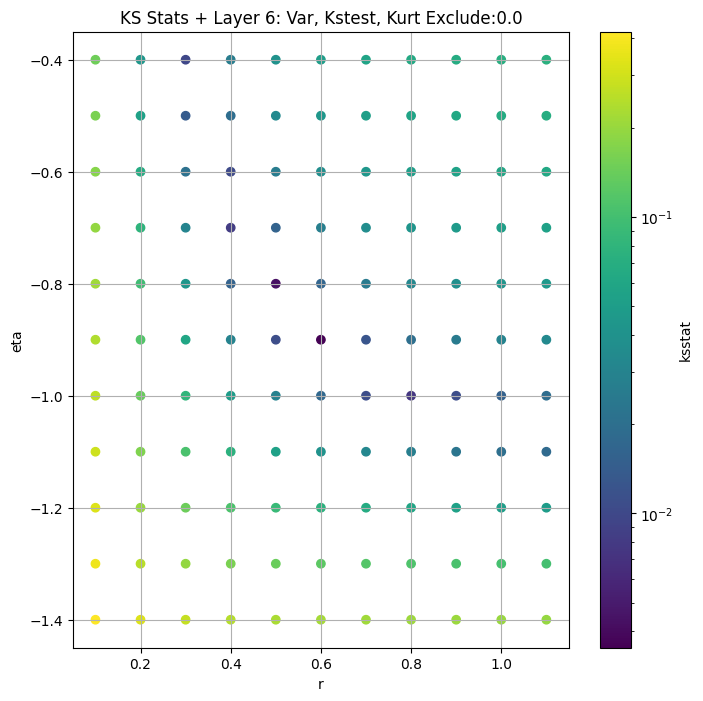

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.005735103184349444 10.670525


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.0063462889243668386 10.279034


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.006728077513916519 10.082465


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.007074000820366411 9.913464


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.007690494156086719 9.761157


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.00882131869670455 9.490145


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.007287504610267392 9.250103


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.007644611580388316 9.032088


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.00799254540395583 8.8315


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.00832721157115962 8.644835


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.00974674243394047 8.150422
Number of samples: 100000, Without approximation : 7241728


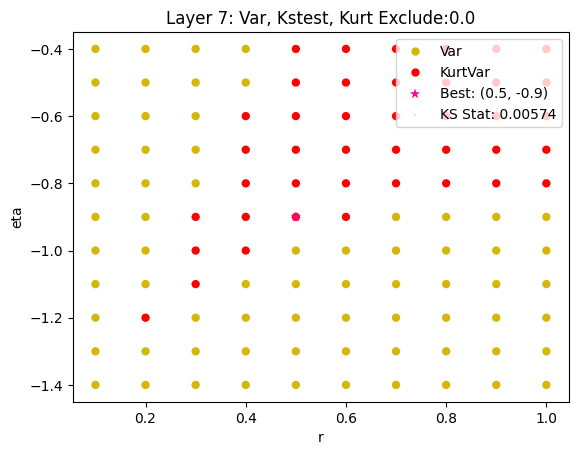

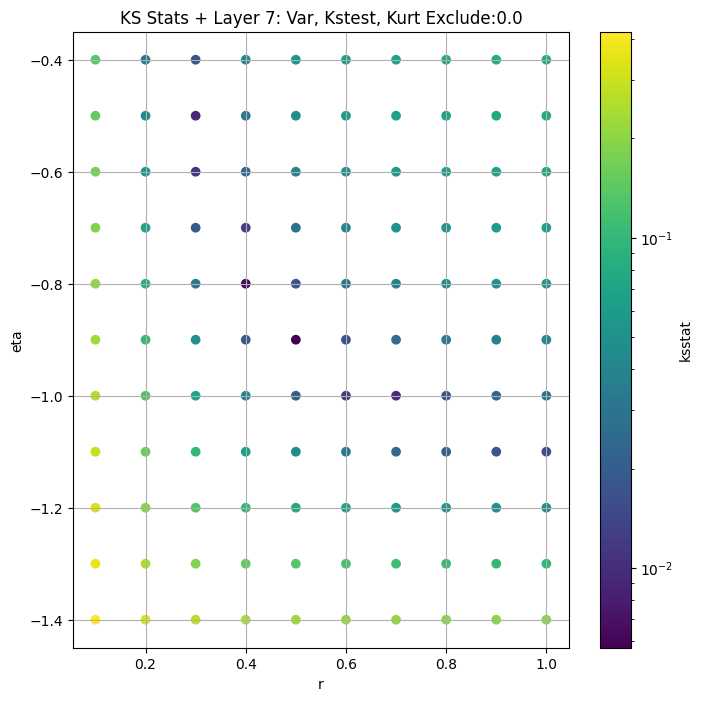

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.006800279305184231 2.3083897


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.005587060359879423 2.2116225


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.006609082206557995 2.1657288


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.006063069436816115 2.12649


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.006093241530887583 2.091209


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.007084236743624871 2.028596


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.008355954967204052 1.9733399


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.00923879349475637 1.9234284


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.009652448395826962 1.8776474


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.010070971535228124 1.8352485


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.010043102443940029 1.7234443
Number of samples: 100000, Without approximation : 28966912


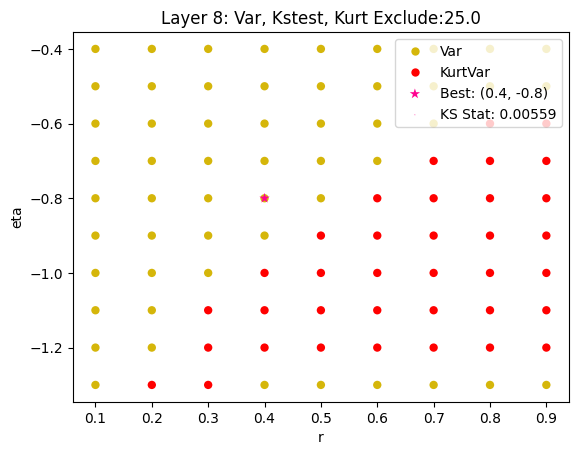

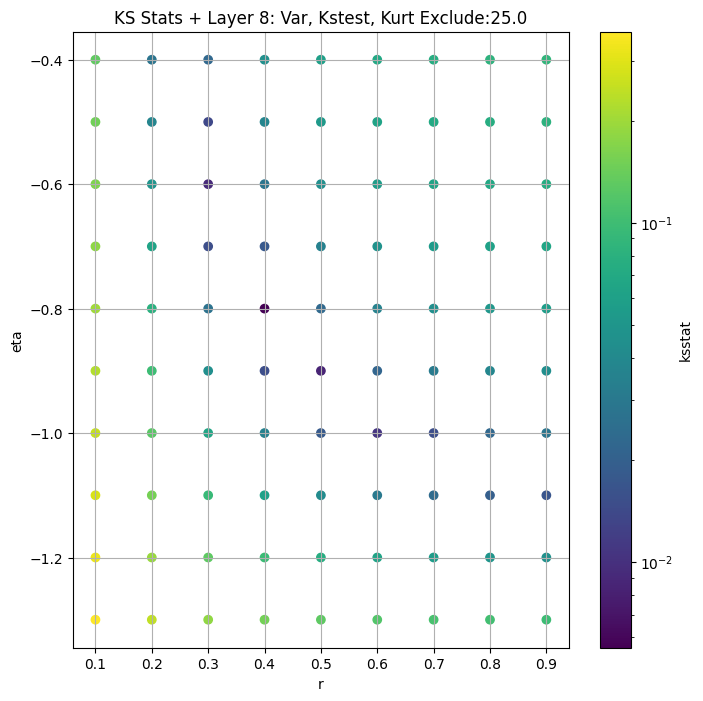

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.006470270546481305 0.51185393


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.00820160006778714 0.4854656


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.006799433133807549 0.47402504


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.0077438709877747786 0.4643426


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.006937426455722706 0.45572504


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.007356401517221778 0.44060853


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.0070534401081532305 0.42741957


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.0077800675990794335 0.41559988


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.00883865422056905 0.40483606


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.009130446816265236 0.39491874


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.010462674158287832 0.36896864
Number of samples: 100000, Without approximation : 115867648


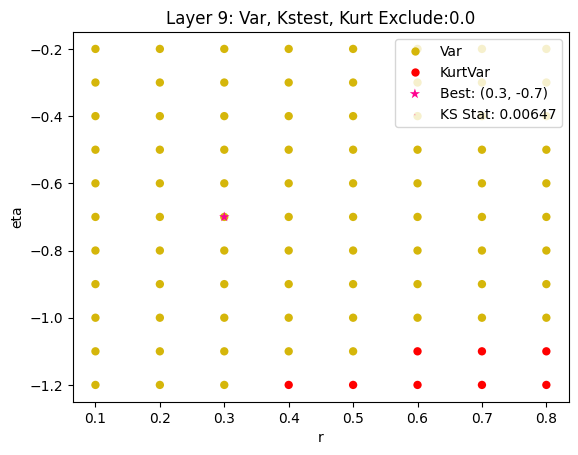

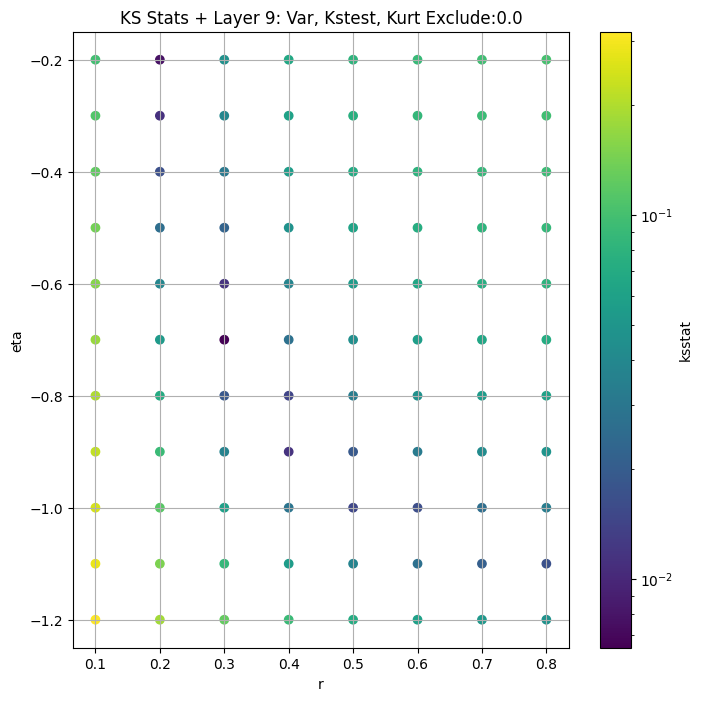

####
Layer  10


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 0 0.008019990340438987 0.11719494


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 25 0.007609528414304068 0.110551976


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 50 0.00843790785350862 0.10741906


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 75 0.008961945482169331 0.10481041


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 100 0.00893540676298299 0.102518395


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 150 0.008856538705888428 0.098553374


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 200 0.010441188573897753 0.095150076


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 250 0.008795678475709945 0.09213975


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 300 0.009284812931768305 0.089426845


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 350 0.010280343594510633 0.086950414


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 500 0.011190162011561311 0.08057022
Number of samples: 100000, Without approximation : 463470592


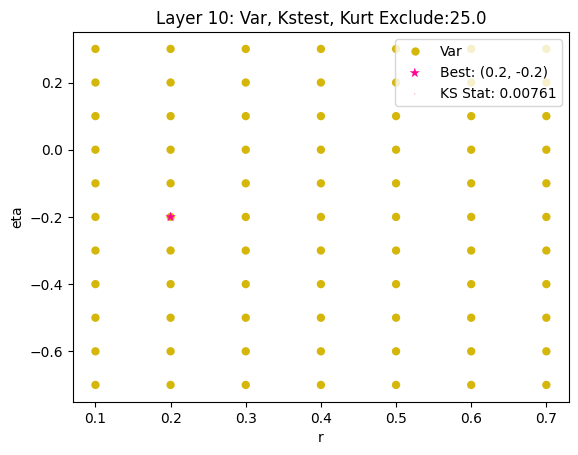

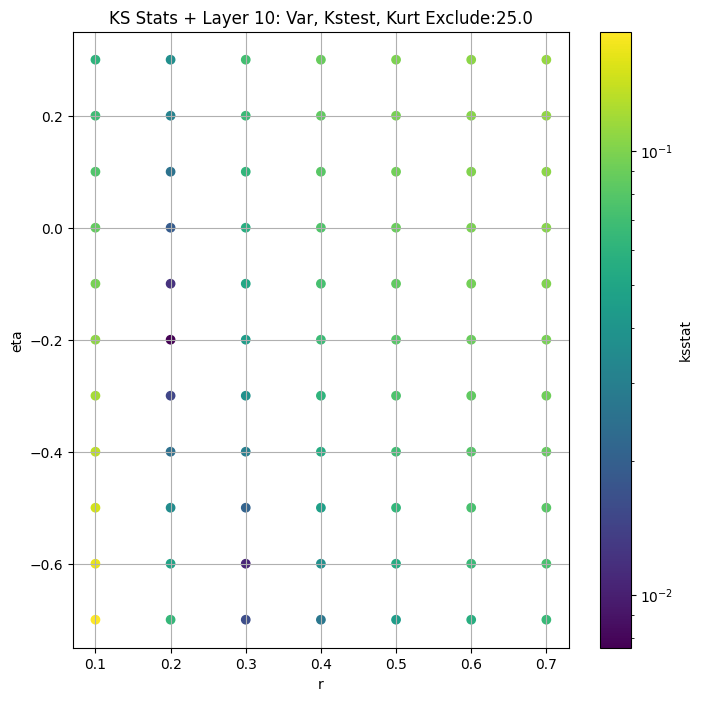

obs_var    var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                  
2      9603.463000  9062.190000  10164.071000   1.545066    1.144739   
3      2720.834200  2572.354200   2874.905000   2.626364    2.173408   
4       753.940200   707.069800    802.806600   4.000318    3.232317   
5       194.982000   181.976300    208.784120   5.163689    4.028322   
6        46.944320    43.397610     51.023575   7.649170    5.101356   
7        10.670525     9.762846     12.098597  14.009258    6.096832   
8         2.308390     2.097086      2.657379  17.870512    6.868606   
9         0.511854     0.459437      0.619605  29.756325    8.036207   
10        0.117195     0.104283      0.139264  28.386827   10.054461   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.002595           7072             0.009950        2.2         -0.3   
3        3.215686          28288             0.002474        1.1         -0.6   
4        5.090291         113152             0.003090        0.9         -0.8   
5        8.982092         452608             0.004044        0.8         -0.9   
6       20.824207        1810432             0.003526        0.6         -0.9   
7       66.927185        7241728             0.005735        0.5         -0.9   
8       87.880844       28966912             0.005587        0.4         -0.8   
9      173.595060      115867648             0.006470        0.3         -0.7   
10     137.195070      463470592             0.007610        0.2         -0.2   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       15644.023039                     0.0         9603.463000   
3        3406.397763                     0.0         2720.834200   
4         936.634084                     0.0          753.940200   
5         233.689953                    25.0          190.702440   
6          31.201040                     0.0           46.944320   
7           4.041865                     0.0           10.670525   
8           0.245335                    25.0            2.211622   
9           0.006418                     0.0            0.511854   
10          0.000003                    25.0            0.110552   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.016126  
3                     0.008069  
4                     0.004036  
5                     0.002018  
6                     0.001009  
7                     0.000505  
8                     0.000252  
9                     0.000126  
10                    0.000063

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/540 [00:00<?, ?it/s]

Finding Minimum after computing 540 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.02459772991009812, var: 7297.20849609375


  0%|          | 0/540 [00:00<?, ?it/s]

Finding Minimum after computing 540 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.02111952800752337, var: 7680.7294921875


  0%|          | 0/540 [00:00<?, ?it/s]

Finding Minimum after computing 540 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.017202839807004655, var: 8126.701171875


  0%|          | 0/540 [00:00<?, ?it/s]

Finding Minimum after computing 540 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.012477996671261926, var: 8695.8037109375


  0%|          | 0/540 [00:00<?, ?it/s]

Finding Minimum after computing 540 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.00993035761821659, var: 9603.462890625
Number of samples: 7072, Without approximation : 7072


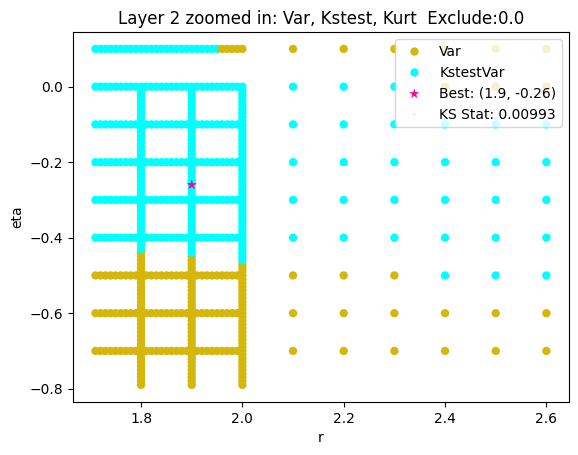

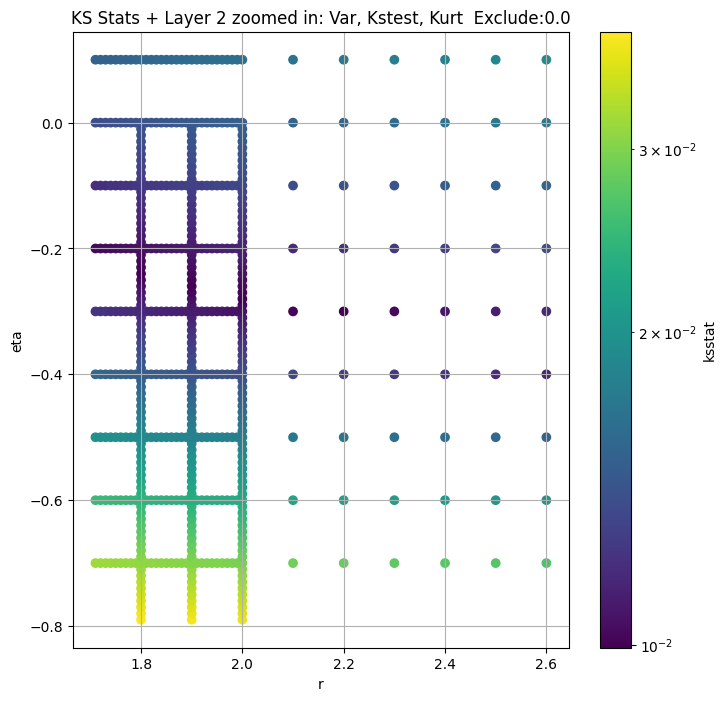

Layer 3


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.007727445965830082, var: 2411.292724609375


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.0064130936014807904, var: 2470.004638671875


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.004842713917418584, var: 2535.35693359375


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.0033650620956795496, var: 2613.642333984375


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.0024694591152368828, var: 2720.834228515625
Number of samples: 28288, Without approximation : 28288


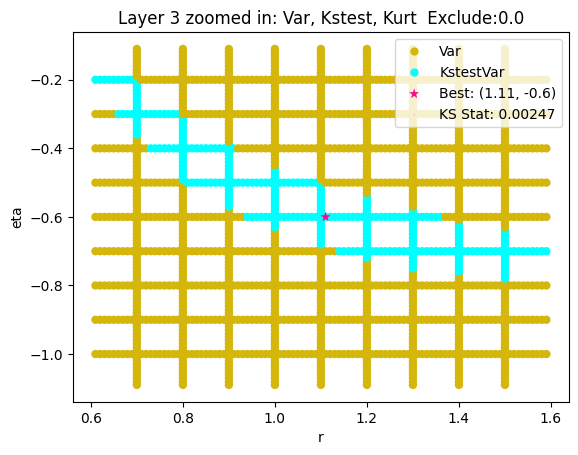

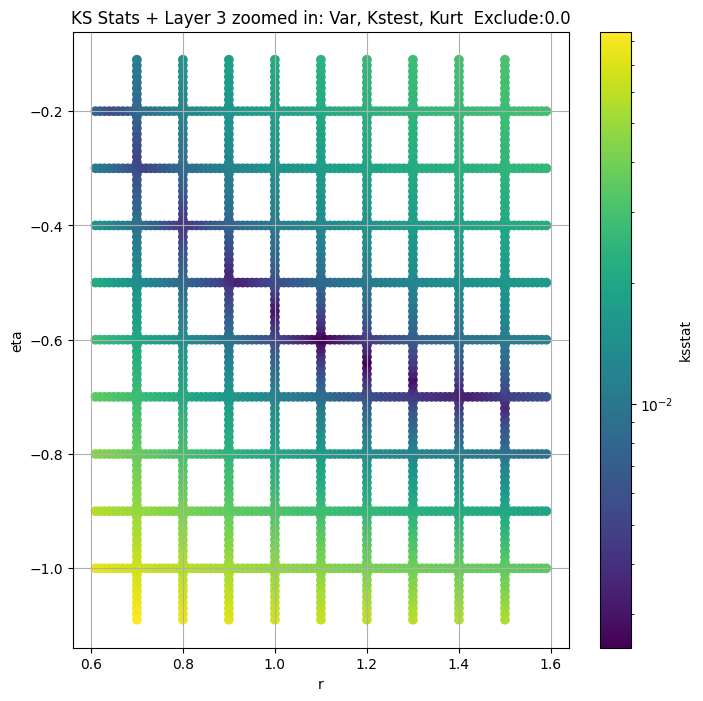

Layer 4


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.004269965933395514, var: 713.26220703125


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.0037486745705736513, var: 721.1729736328125


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.0035922628577616036, var: 729.7652587890625


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.003262995165283132, var: 739.4489135742188


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.0030896841960712518, var: 753.940185546875
Number of samples: 100000, Without approximation : 113152


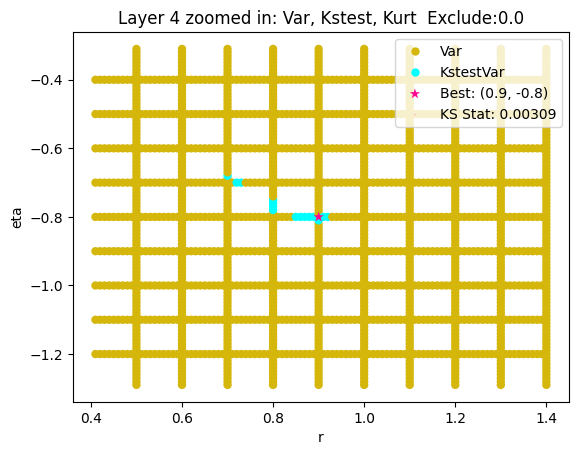

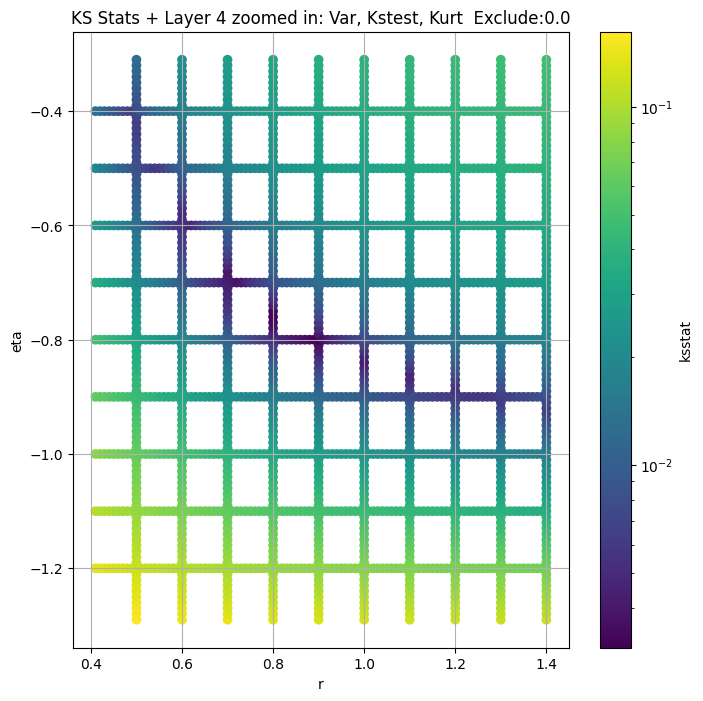

Layer 5


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 25.0 + 100 = 125, ksstat: 0.0049842664622079536, var: 181.15939331054688


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 25.0 + 75 = 100, ksstat: 0.00470592009137738, var: 183.22181701660156


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 25.0 + 50 = 75, ksstat: 0.004626752946297219, var: 185.44461059570312


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 25.0 + 25 = 50, ksstat: 0.004318434911119495, var: 187.88856506347656


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 25.0 + 0 = 25, ksstat: 0.0039294622706994575, var: 190.7024383544922


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 25.0 + -25 = 0, ksstat: 0.0035060532550038603, var: 194.98199462890625
Number of samples: 100000, Without approximation : 452608


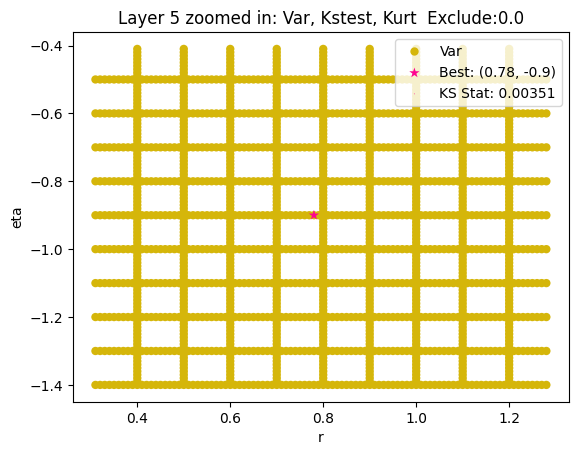

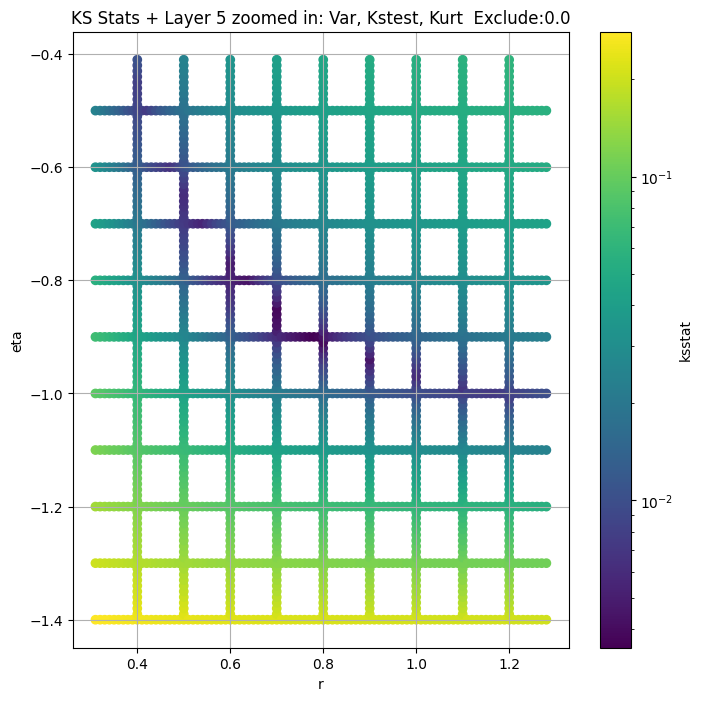

Layer 6


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.005083388240563869, var: 43.53487014770508


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.004581782849474303, var: 44.14619445800781


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.004429156559111136, var: 44.824100494384766


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.003995028834840486, var: 45.61225509643555


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.0035264952500849156, var: 46.94432067871094
Number of samples: 100000, Without approximation : 1810432


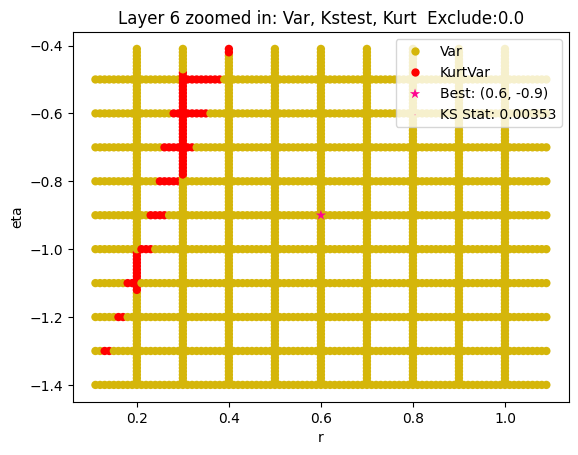

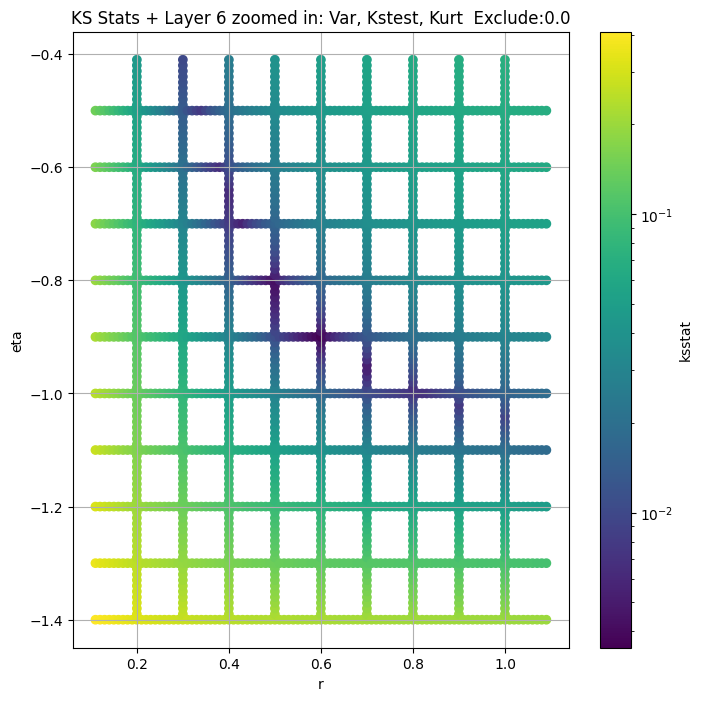

Layer 7


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.005592669890821633, var: 9.761157035827637


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.005177321305006255, var: 9.913463592529297


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.005114134315658714, var: 10.082465171813965


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.00473198138681713, var: 10.279033660888672


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.004649649624301699, var: 10.670524597167969
Number of samples: 100000, Without approximation : 7241728


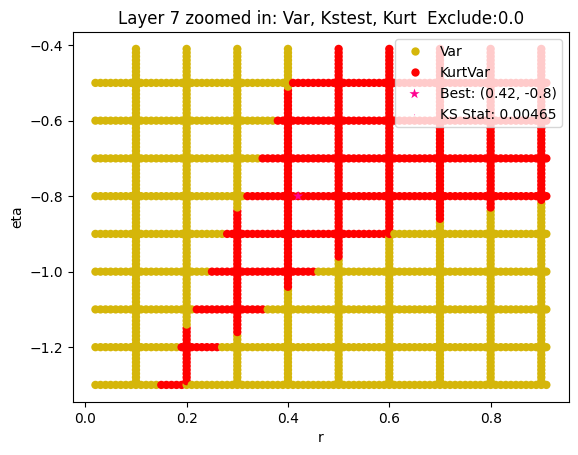

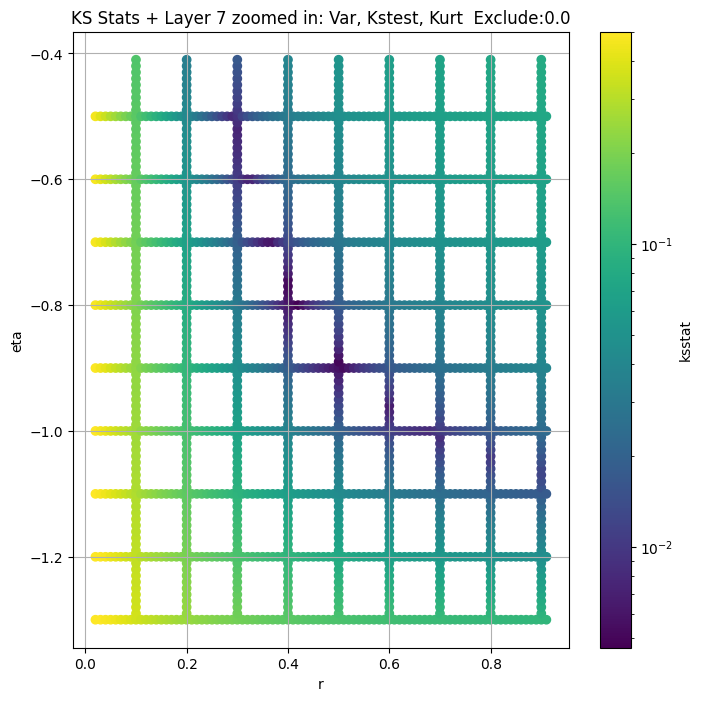

Layer 8


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 8, 25.0 + 100 = 125, ksstat: 0.006141178728307384, var: 2.0587878227233887


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 8, 25.0 + 75 = 100, ksstat: 0.006093241530887583, var: 2.0912089347839355


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 8, 25.0 + 50 = 75, ksstat: 0.006063069436816115, var: 2.1264901161193848


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 8, 25.0 + 25 = 50, ksstat: 0.005980774808963807, var: 2.165728807449341


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 8, 25.0 + 0 = 25, ksstat: 0.005587060359879423, var: 2.211622476577759


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 8, 25.0 + -25 = 0, ksstat: 0.004902459124248915, var: 2.308389663696289
Number of samples: 100000, Without approximation : 28966912


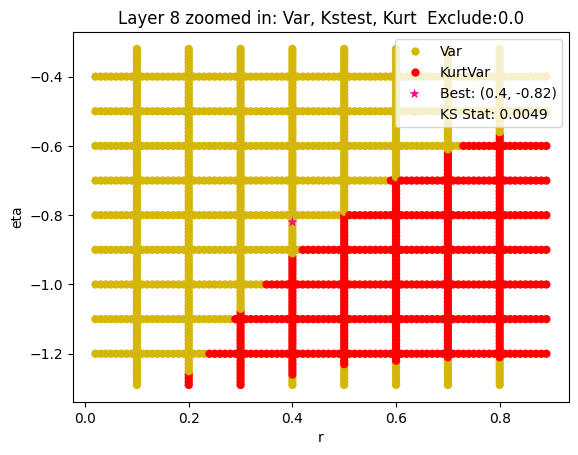

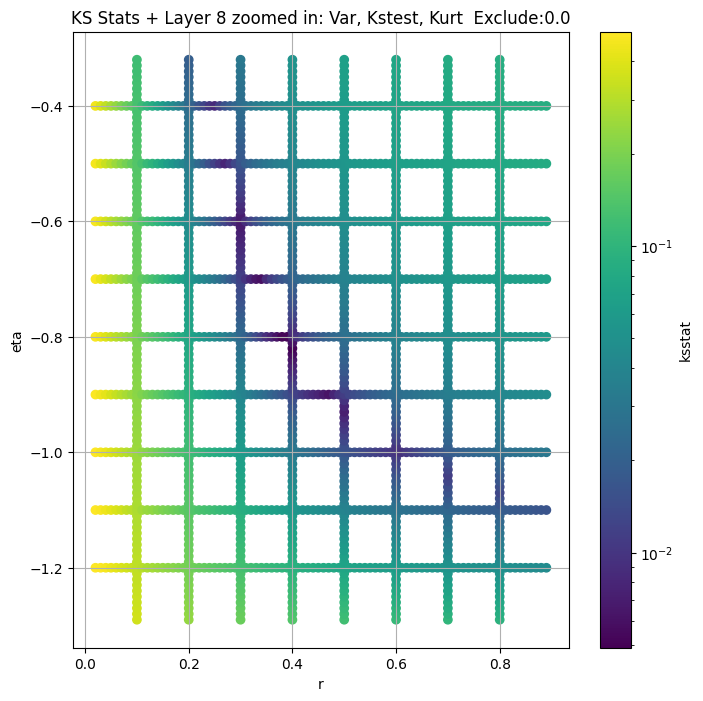

Layer 9


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 9, 0.0 + 100 = 100, ksstat: 0.0061293762683219885, var: 0.4557250440120697


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 9, 0.0 + 75 = 75, ksstat: 0.005540020188766849, var: 0.4643425941467285


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 9, 0.0 + 50 = 50, ksstat: 0.005307404308059448, var: 0.47402504086494446


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 9, 0.0 + 25 = 25, ksstat: 0.0056983133374857164, var: 0.4854655861854553


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 9, 0.0 + 0 = 0, ksstat: 0.004721523466334782, var: 0.5118539333343506
Number of samples: 100000, Without approximation : 115867648


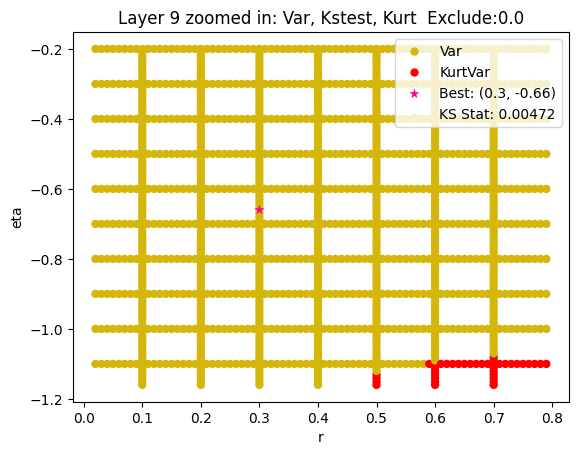

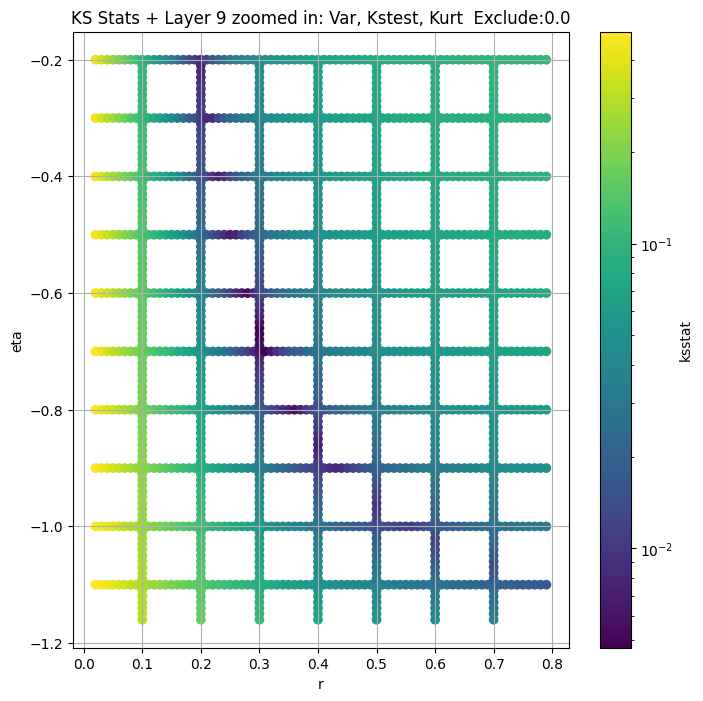

Layer 10


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
layer 10, 25.0 + 100 = 125, ksstat: 0.00757212271942076, var: 0.10045008361339569


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
layer 10, 25.0 + 75 = 100, ksstat: 0.007491433840146167, var: 0.10251839458942413


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
layer 10, 25.0 + 50 = 75, ksstat: 0.00756550335642614, var: 0.10481040924787521


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
layer 10, 25.0 + 25 = 50, ksstat: 0.007459334018598773, var: 0.10741905868053436


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
layer 10, 25.0 + 0 = 25, ksstat: 0.007496670121353244, var: 0.11055197566747665


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
layer 10, 25.0 + -25 = 0, ksstat: 0.007473583821161978, var: 0.11719494313001633
Number of samples: 100000, Without approximation : 463470592


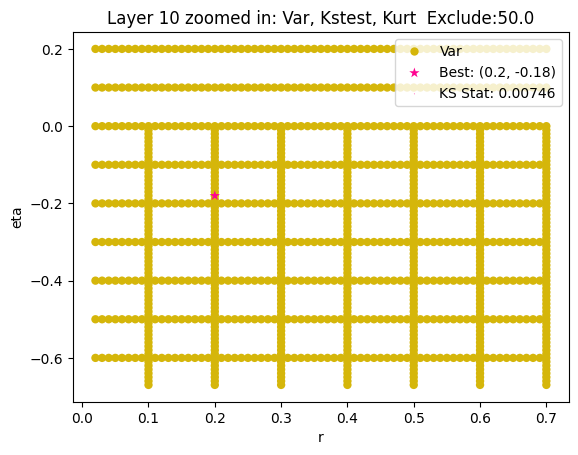

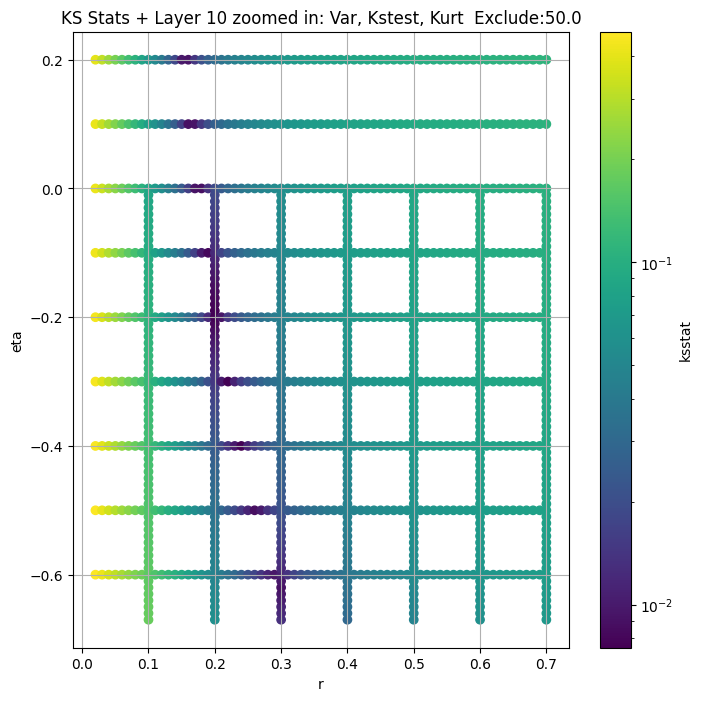

obs_var    var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                  
2      9603.463000  9062.190000  10164.071000   1.545066    1.144739   
3      2720.834200  2572.354200   2874.905000   2.626364    2.173408   
4       753.940200   707.069800    802.806600   4.000318    3.232317   
5       194.982000   181.976300    208.784120   5.163689    4.028322   
6        46.944320    43.397610     51.023575   7.649170    5.101356   
7        10.670525     9.762846     12.098597  14.009258    6.096832   
8         2.308390     2.097086      2.657379  17.870512    6.868606   
9         0.511854     0.459437      0.619605  29.756325    8.036207   
10        0.117195     0.104283      0.139264  28.386827   10.054461   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.002595           7072             0.009950        2.2         -0.3   
3        3.215686          28288             0.002474        1.1         -0.6   
4        5.090291         113152             0.003090        0.9         -0.8   
5        8.982092         452608             0.004044        0.8         -0.9   
6       20.824207        1810432             0.003526        0.6         -0.9   
7       66.927185        7241728             0.005735        0.5         -0.9   
8       87.880844       28966912             0.005587        0.4         -0.8   
9      173.595060      115867648             0.006470        0.3         -0.7   
10     137.195070      463470592             0.007610        0.2         -0.2   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       15644.023039                     0.0         9603.462891   
3        3406.397763                     0.0         2720.834229   
4         936.634084                     0.0          753.940200   
5         233.689953                    25.0          194.981995   
6          31.201040                     0.0           46.944320   
7           4.041865                     0.0           10.670525   
8           0.245335                    25.0            2.308390   
9           0.006418                     0.0            0.511854   
10          0.000003                    25.0            0.107419   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.016126          0.009930    1.90     -0.26   
3                     0.008069          0.002469    1.11     -0.60   
4                     0.004036          0.003090    0.90     -0.80   
5                     0.002018          0.003506    0.78     -0.90   
6                     0.001009          0.003526    0.60     -0.90   
7                     0.000505          0.004650    0.42     -0.80   
8                     0.000252          0.004902    0.40     -0.82   
9                     0.000126          0.004722    0.30     -0.66   
10                    0.000063          0.007459    0.20     -0.18   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      14340.484740                  0.0        17901  
3       3441.853527                  0.0       305853  
4        936.634084                  0.0       190944  
5        228.891876                  0.0       143208  
6         31.201040                  0.0       143208  
7          1.511761                  0.0        84864  
8          0.270411                  0.0        80554  
9          0.005687                  0.0        84864  
10         0.000002                 50.0        31824

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

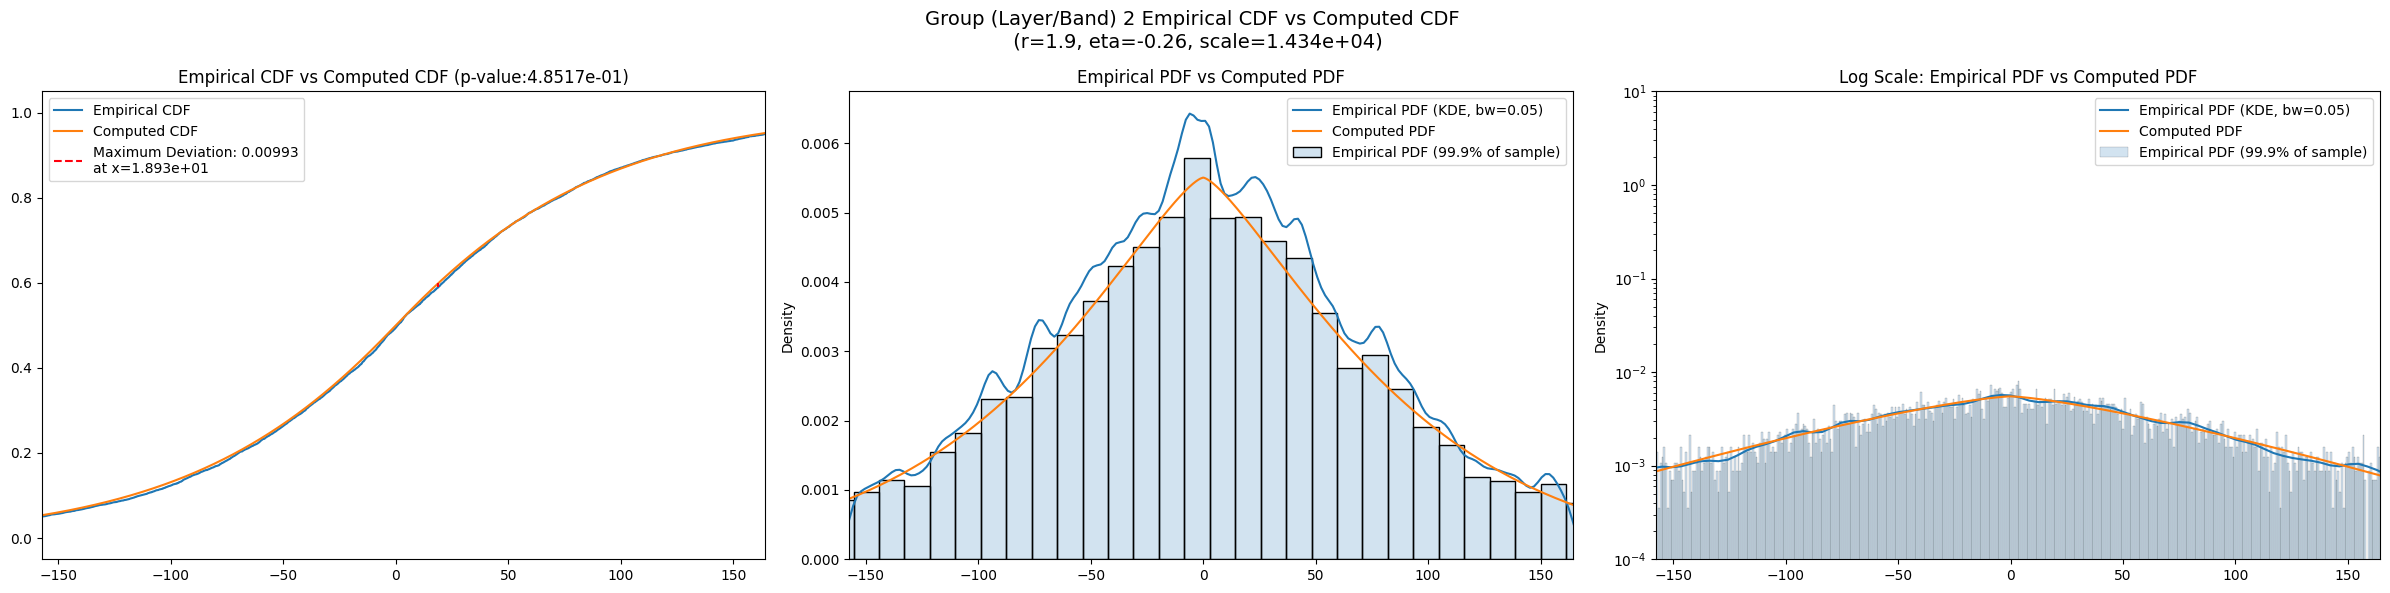

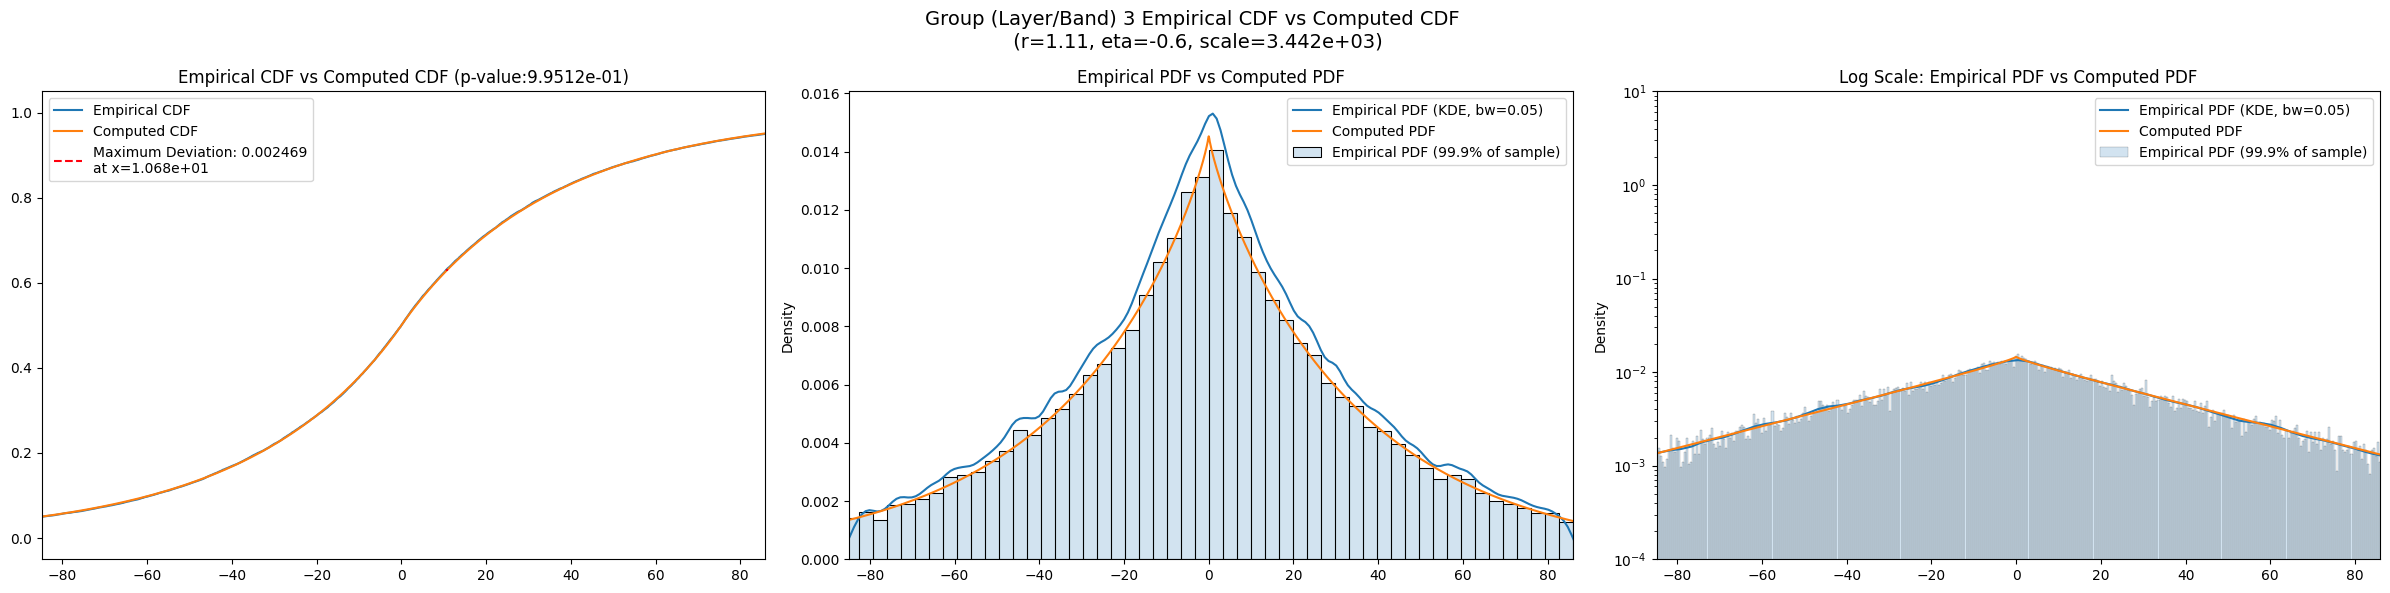

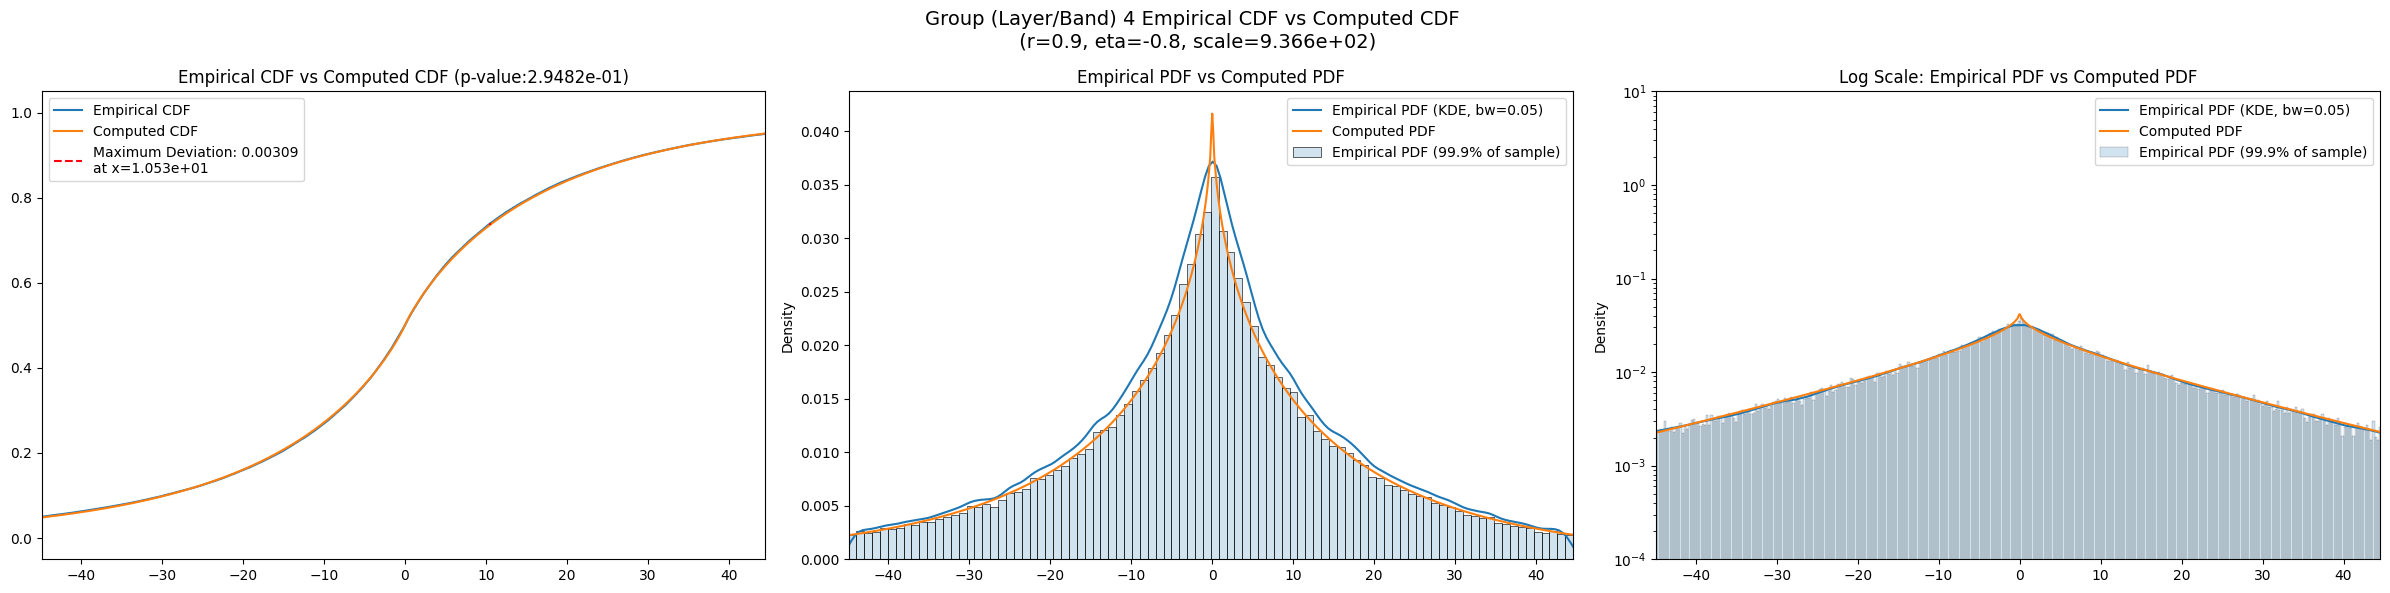

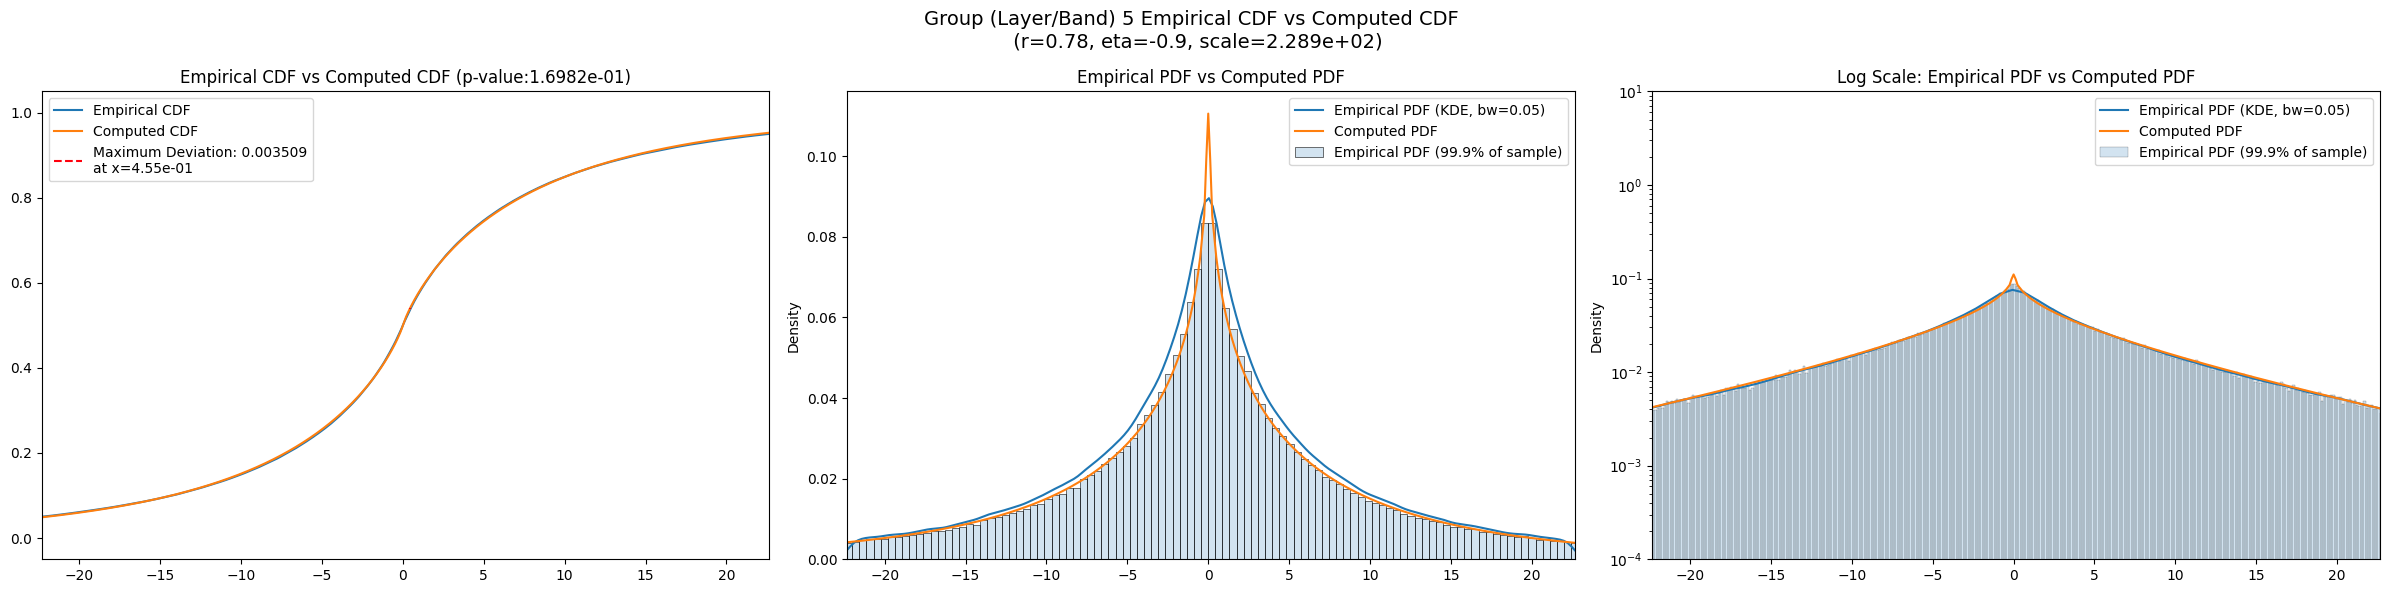

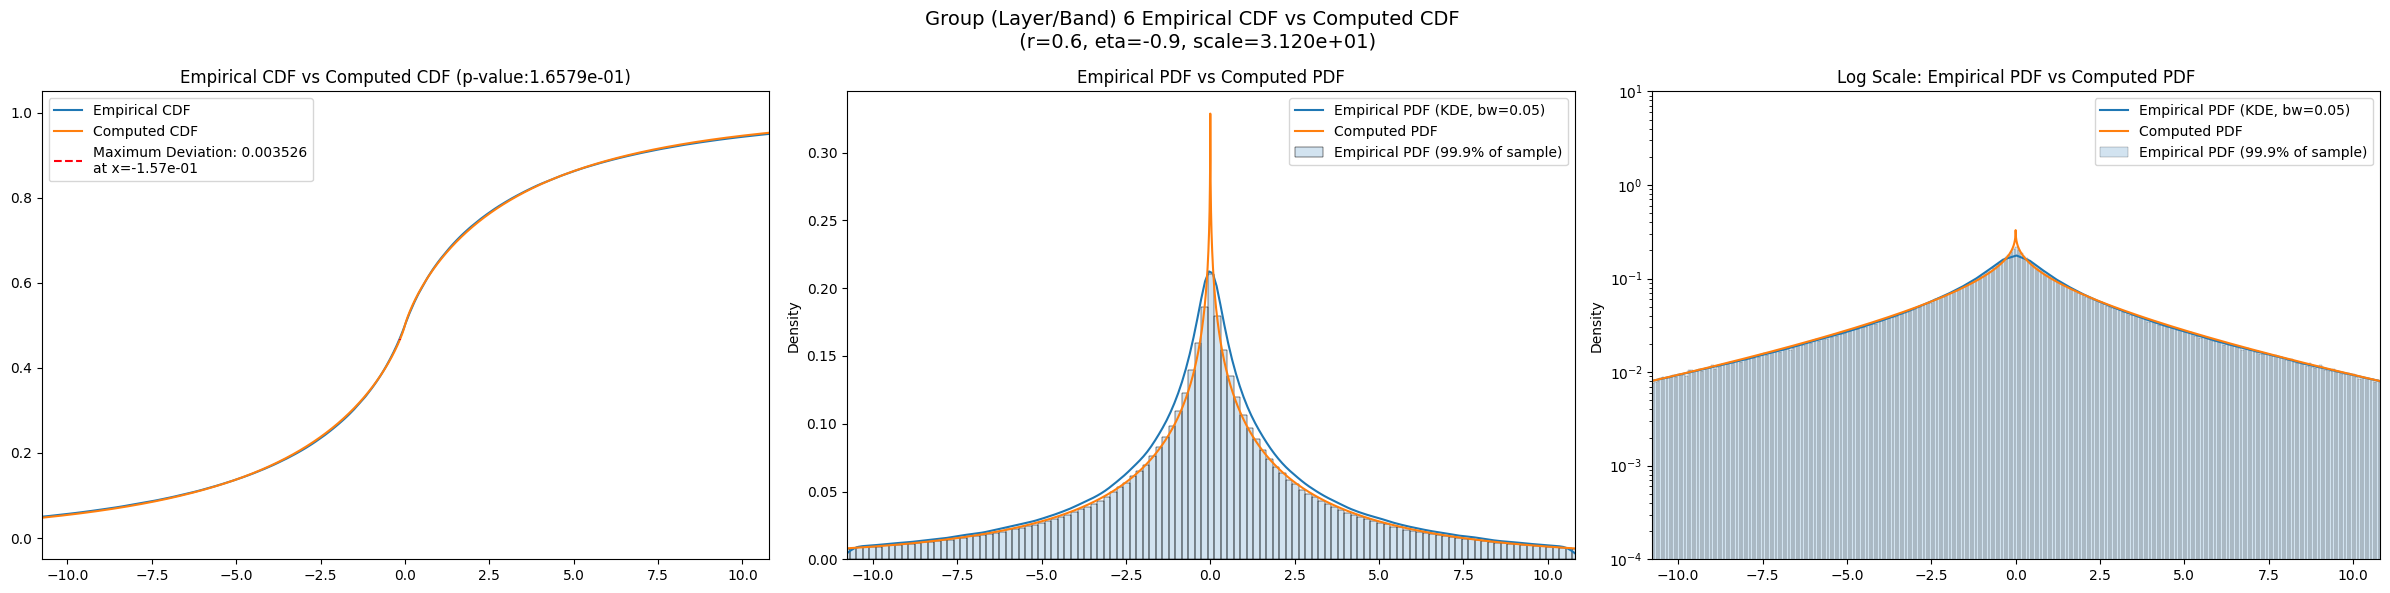

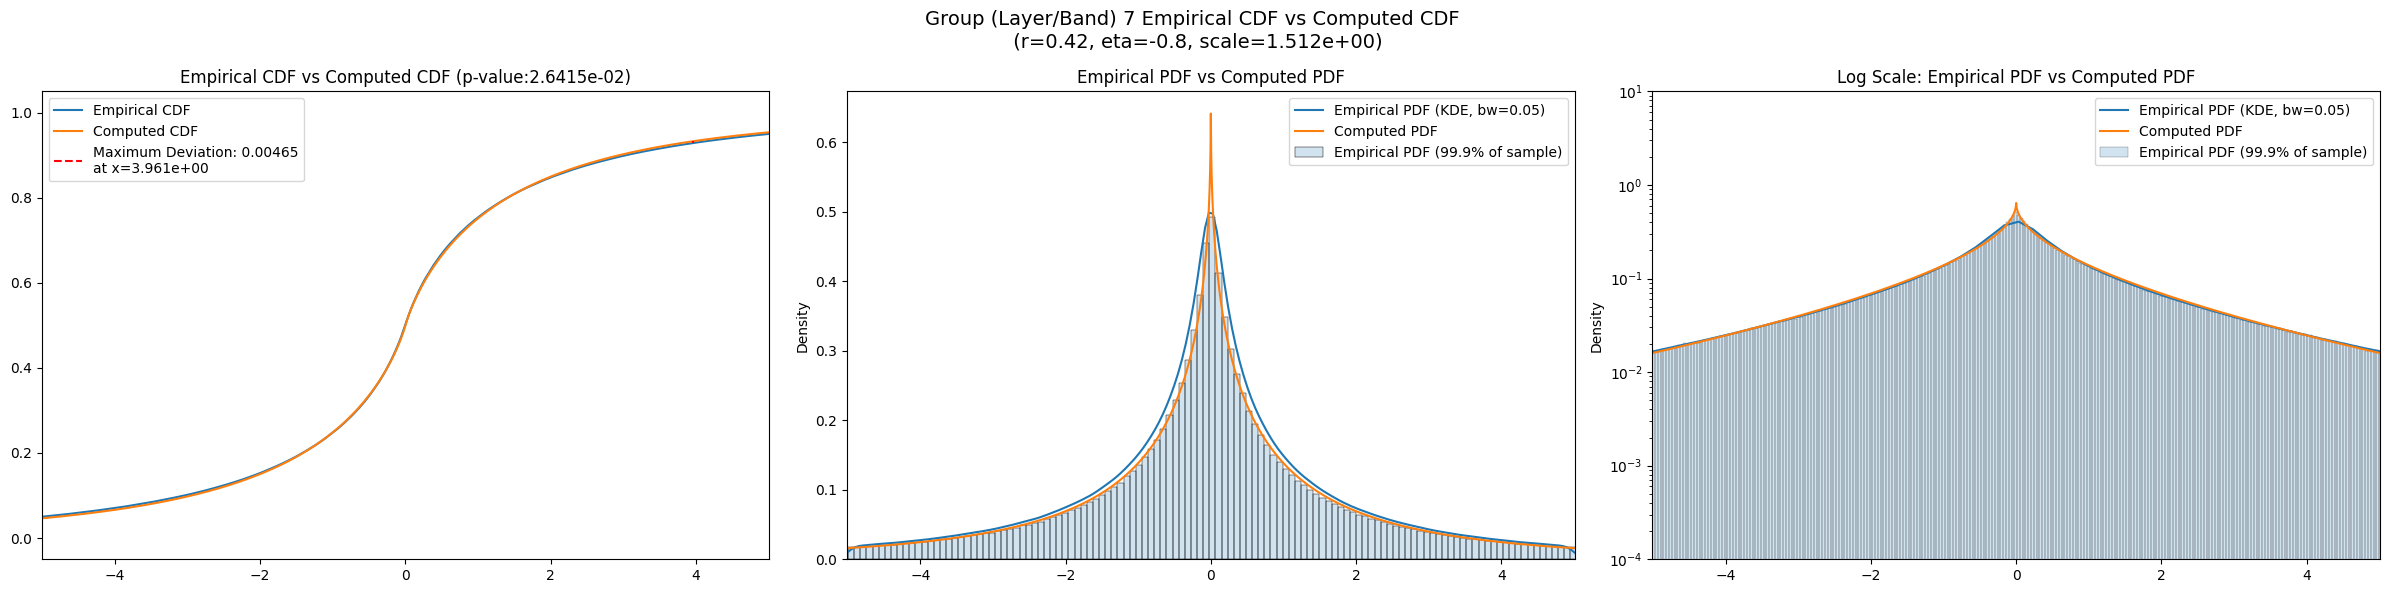

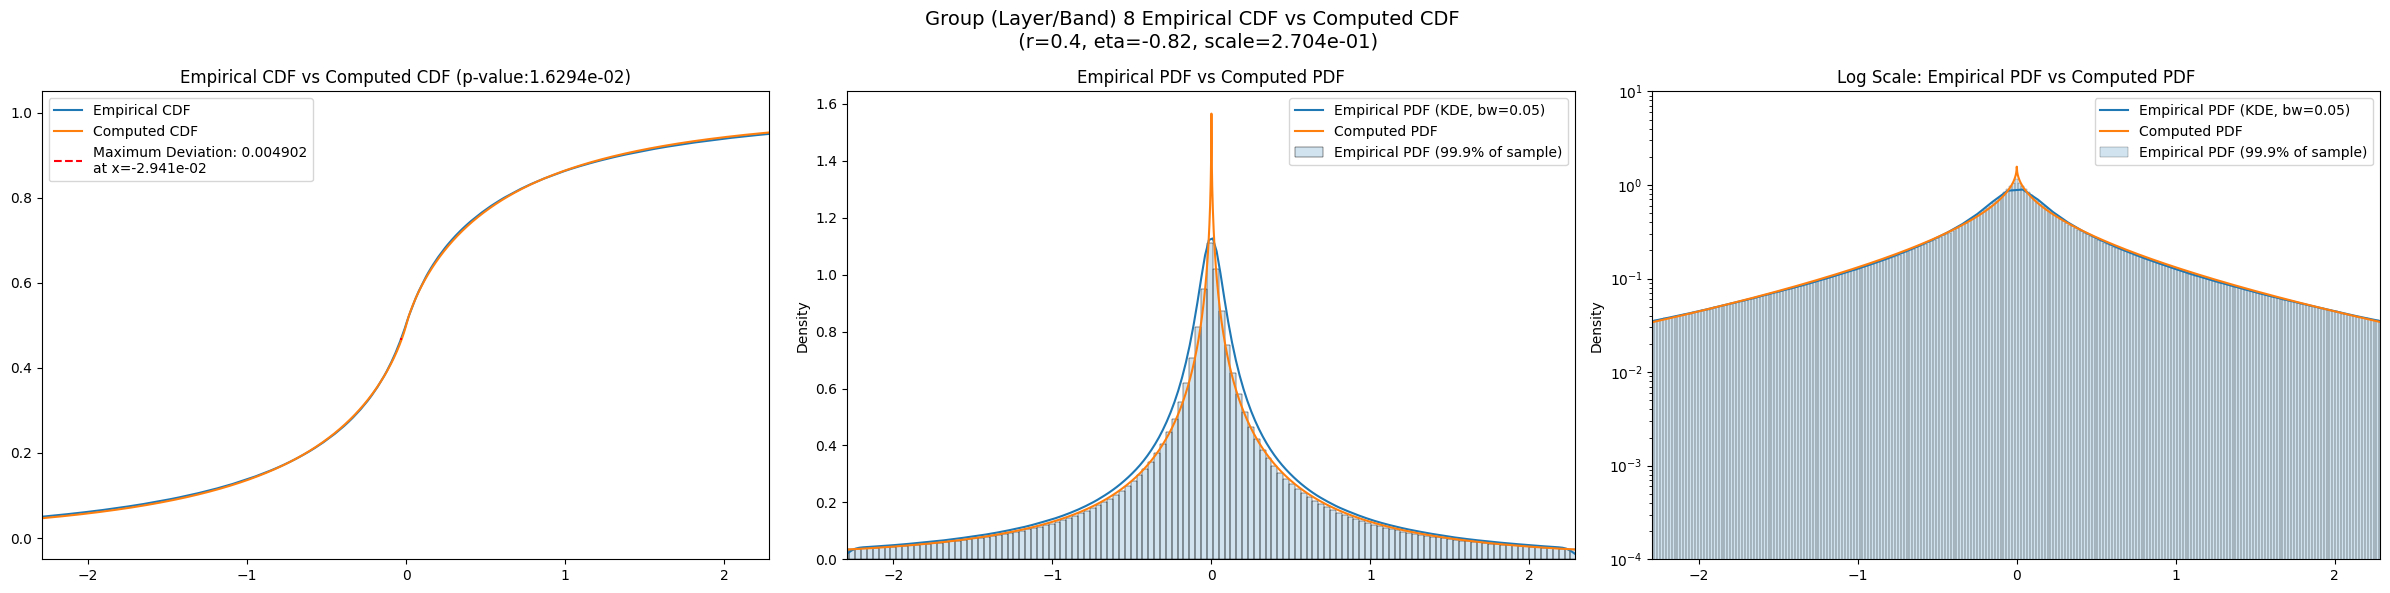

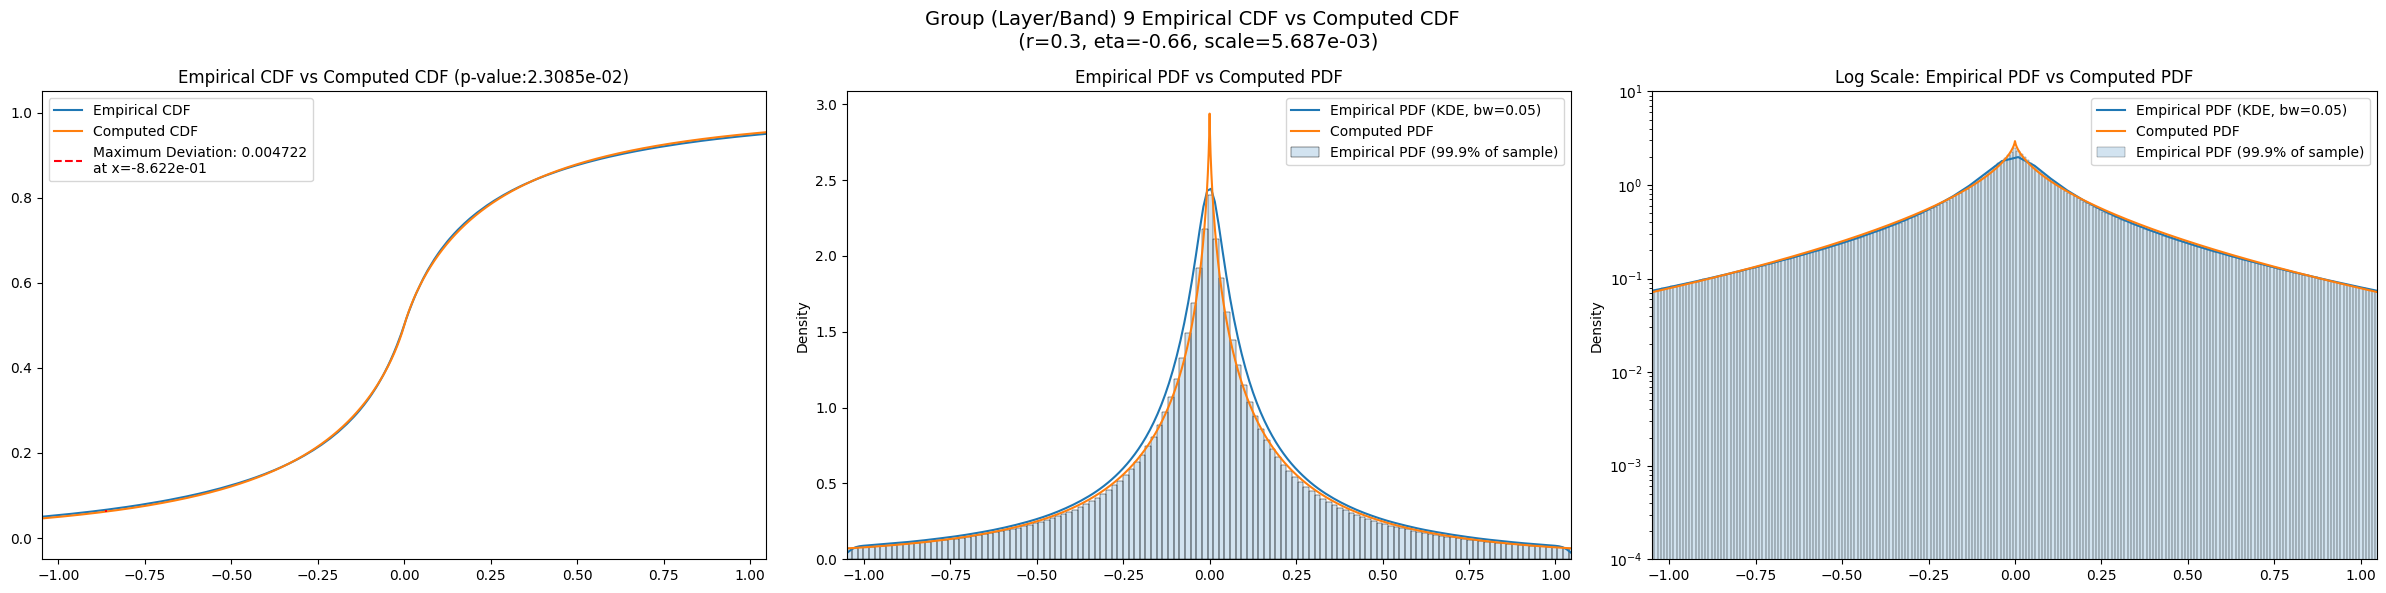

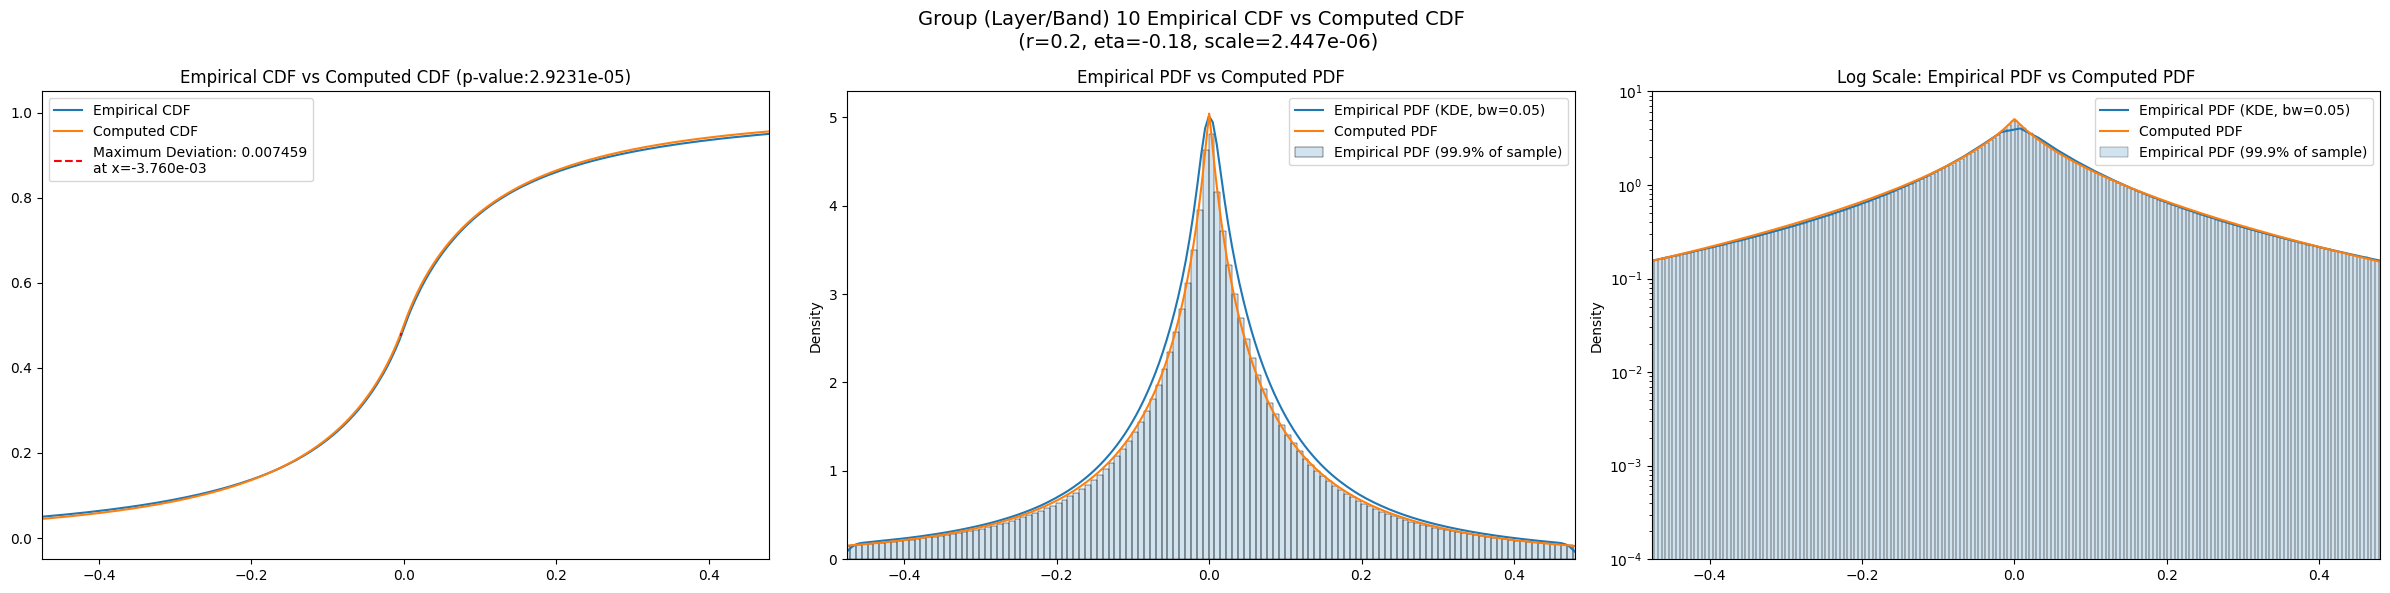

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                  
2      9603.463000  9062.190000  10164.071000   1.545066    1.144739   
3      2720.834200  2572.354200   2874.905000   2.626364    2.173408   
4       753.940200   707.069800    802.806600   4.000318    3.232317   
5       194.982000   181.976300    208.784120   5.163689    4.028322   
6        46.944320    43.397610     51.023575   7.649170    5.101356   
7        10.670525     9.762846     12.098597  14.009258    6.096832   
8         2.308390     2.097086      2.657379  17.870512    6.868606   
9         0.511854     0.459437      0.619605  29.756325    8.036207   
10        0.117195     0.104283      0.139264  28.386827   10.054461   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.002595           7072             0.009950        2.2         -0.3   
3        3.215686          28288             0.002474        1.1         -0.6   
4        5.090291         113152             0.003090        0.9         -0.8   
5        8.982092         452608             0.004044        0.8         -0.9   
6       20.824207        1810432             0.003526        0.6         -0.9   
7       66.927185        7241728             0.005735        0.5         -0.9   
8       87.880844       28966912             0.005587        0.4         -0.8   
9      173.595060      115867648             0.006470        0.3         -0.7   
10     137.195070      463470592             0.007610        0.2         -0.2   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       87.634100              0.022849          1.222370e-03   
3      ...       41.695500              0.031498          8.132330e-25   
4      ...       19.617300              0.042641         3.278320e-179   
5      ...        9.120170              0.049939          0.000000e+00   
6      ...        4.084260              0.054908          0.000000e+00   
7      ...        1.800500              0.058979          0.000000e+00   
8      ...        0.797998              0.061103          0.000000e+00   
9      ...        0.359454              0.061573          0.000000e+00   
10     ...        0.166707              0.059286          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          78.216400             0.018117         1.903070e-02  62.288600   
3          36.344000             0.003963         7.642640e-01  30.364900   
4          17.067100             0.015111         7.112170e-23  13.845300   
5           7.948540             0.022551        2.184870e-200   6.379690   
6           3.556270             0.027793         0.000000e+00   2.833780   
7           1.566720             0.032048         0.000000e+00   1.241130   
8           0.695426             0.034198         0.000000e+00   0.549646   
9           0.314735             0.034544         0.000000e+00   0.248185   
10          0.146401             0.032536         0.000000e+00   0.114663   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.019767   7.854130e-03          4.851699e-01  
3           0.010939   2.278460e-03          9.951198e-01  
4           0.019049   4.271520e-36          2.297489e-01  
5           0.025374  1.401530e-253          2.934170e-05  
6           0.030152   0.000000e+00          5.544588e-20  
7           0.033870   0.000000e+00         2.055019e-136  
8           0.035589   0.000000e+00          0.000000e+00  
9           0.034967   0.000000e+00          0.000000e+00  
10          0.032715   0.000000e+00          0.000000e+00  

[9

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.009950                 0.016126          0.009930   
3                 0.002474                 0.008069          0.002469   
4                 0.003090                 0.004036          0.003090   
5                 0.004044                 0.002018          0.003506   
6                 0.003526                 0.001009          0.003526   
7                 0.005735                 0.000505          0.004650   
8                 0.005587                 0.000252          0.004902   
9                 0.006470                 0.000126          0.004722   
10                0.007610                 0.000063          0.007459   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.022849             0.018117       0.019767  
3                  0.031498             0.003963       0.010939  
4                  0.042641             0.015111       0.019049  
5                  0.049939             0.022551       0.025374  
6                  0.054908             0.027793       0.030152  
7                  0.058979             0.032048       0.033870  
8                  0.061103             0.034198       0.035589  
9                  0.061573             0.034544       0.034967  
10                 0.059286             0.032536       0.032715

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2             9603.462891          0.009930    1.90     -0.26  14340.484740   
3             2720.834229          0.002469    1.11     -0.60   3441.853527   
4              753.940200          0.003090    0.90     -0.80    936.634084   
5              194.981995          0.003506    0.78     -0.90    228.891876   
6               46.944320          0.003526    0.60     -0.90     31.201040   
7               10.670525          0.004650    0.42     -0.80      1.511761   
8                2.308390          0.004902    0.40     -0.82      0.270411   
9                0.511854          0.004722    0.30     -0.66      0.005687   
10               0.107419          0.007459    0.20     -0.18      0.000002   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                      0.0  
7                      0.0  
8                      0.0  
9                      0.0  
10                    50.0

In [21]:
eng.quit()